In [0]:
from fastai.vision import *

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:

from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

In [4]:
path = untar_data(URLs.PLANET_SAMPLE)
path.ls()


[PosixPath('/root/.fastai/data/planet_sample/labels.csv'),
 PosixPath('/root/.fastai/data/planet_sample/train'),
 PosixPath('/root/.fastai/data/planet_sample/models')]

In [0]:

#path = untar_data(URLs.PLANET_TINY)
#path.ls()


In [5]:

df = pd.read_csv(path/'labels.csv')
df.head(20)

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road
5,train_13350,clear primary
6,train_19547,agriculture clear primary road
7,train_31388,partly_cloudy primary
8,train_32079,partly_cloudy primary
9,train_9399,agriculture clear primary


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.7, max_zoom=0.7, max_warp=0.) #1.05

In [0]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'labels.csv', folder='train', suffix='.jpg')
       .split_by_rand_pct(0.30)
       .label_from_df(label_delim=' '))

In [0]:
data = (src.transform(tfms, size=224)
        .databunch().normalize(imagenet_stats))

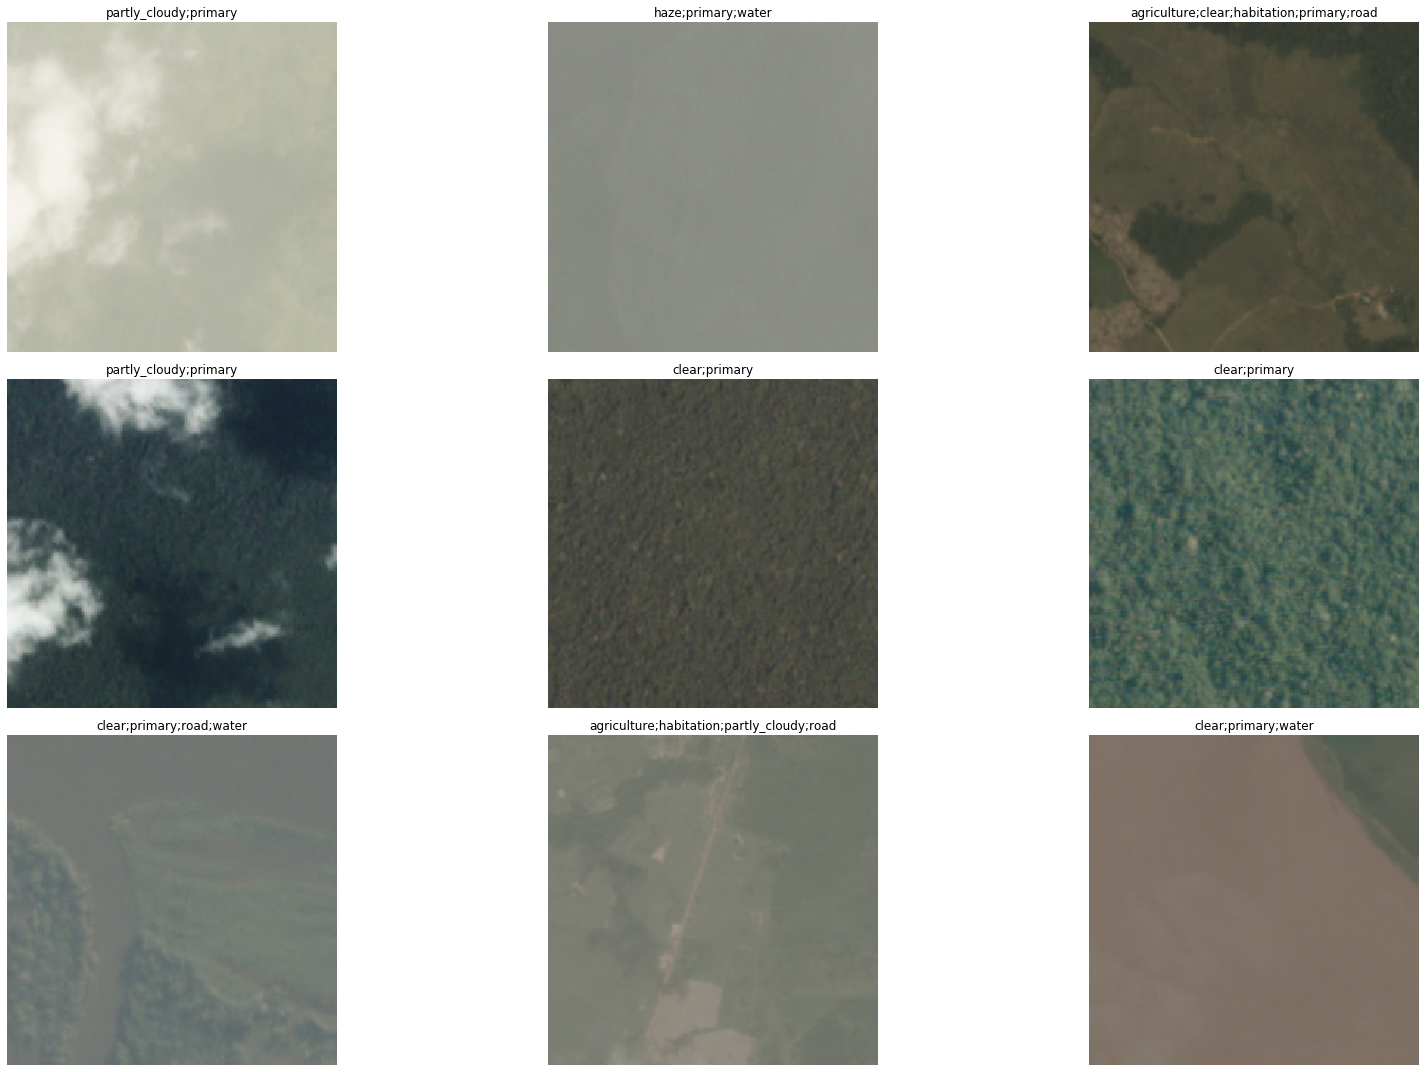

In [17]:
data.show_batch(rows=3, figsize=(25,15))

In [0]:
arch = models.vgg16_bn

In [19]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:10<00:00, 51.1MB/s]


In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


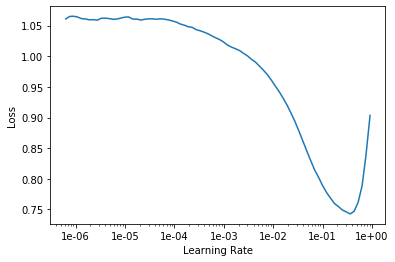

In [21]:
learn.recorder.plot()

In [0]:
from fastai.vision import * 
from fastai import *
from fastai.callbacks import *
import scipy.ndimage

In [0]:
lr = 0.02

In [24]:
learn.fit_one_cycle(2, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.826597,0.382101,0.443542,0.576161,00:08
1,0.551633,0.185955,0.917083,0.841929,00:06


In [0]:
learn.save('Planet-stage-1-vgg16')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


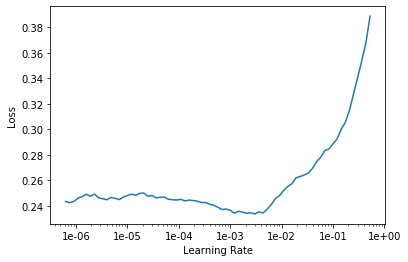

In [28]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.251207,0.176232,0.919375,0.849583,00:08
1,0.238913,0.165454,0.924583,0.864870,00:08
2,0.227646,0.152270,0.930625,0.873603,00:08
3,0.217490,0.142841,0.940208,0.886183,00:08
4,0.207291,0.139631,0.939583,0.893584,00:08
5,0.199957,0.132608,0.942917,0.901941,00:08
6,0.190838,0.134138,0.937708,0.896773,00:08
7,0.180796,0.128296,0.943958,0.895983,00:07
8,0.172296,0.127831,0.946042,0.892308,00:08
9,0.164664,0.127614,0.947708,0.896910,00:08


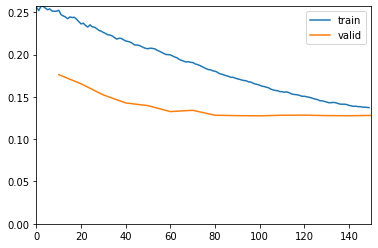

Better model found at epoch 0 with valid_loss value: 0.17623157799243927.
Better model found at epoch 1 with valid_loss value: 0.16545440256595612.
Better model found at epoch 2 with valid_loss value: 0.15227019786834717.
Better model found at epoch 3 with valid_loss value: 0.14284062385559082.
Better model found at epoch 4 with valid_loss value: 0.13963112235069275.
Better model found at epoch 5 with valid_loss value: 0.13260823488235474.
Better model found at epoch 7 with valid_loss value: 0.12829646468162537.
Better model found at epoch 8 with valid_loss value: 0.1278308629989624.
Better model found at epoch 9 with valid_loss value: 0.12761415541172028.


In [29]:
lr=1e-3
learn.fit_one_cycle(15,max_lr=slice(lr/100,lr),callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [0]:
learn.save('Planet-stage-2-vgg16')

In [0]:
learn.load('Planet-stage-2-vgg16');
#learn.purge()

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


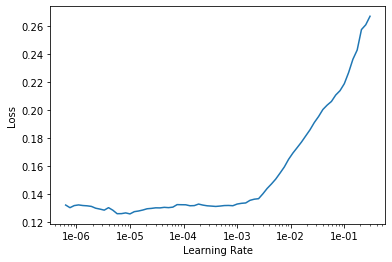

In [34]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.065373,0.126731,0.951458,0.893280,00:08
1,0.063167,0.126697,0.951667,0.895522,00:08
2,0.065563,0.124084,0.951875,0.897771,00:08
3,0.064337,0.123407,0.952708,0.900947,00:08
4,0.064700,0.122843,0.951042,0.900631,00:08
5,0.062423,0.128505,0.951042,0.895550,00:08
6,0.061826,0.136930,0.949792,0.894097,00:08
7,0.060013,0.135735,0.951667,0.897213,00:08
8,0.059382,0.132435,0.949167,0.899574,00:08
9,0.058866,0.141563,0.952917,0.901178,00:08


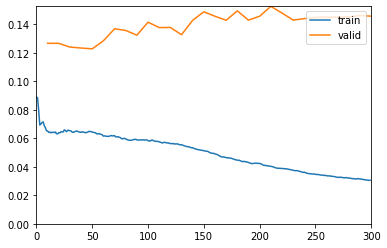

Better model found at epoch 0 with valid_loss value: 0.12673132121562958.
Better model found at epoch 1 with valid_loss value: 0.12669654190540314.
Better model found at epoch 2 with valid_loss value: 0.12408442050218582.
Better model found at epoch 3 with valid_loss value: 0.12340682744979858.
Better model found at epoch 4 with valid_loss value: 0.12284290045499802.


In [40]:
learn.fit_one_cycle(30, max_lr=slice(5e-5, 5e-4),callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [0]:

learn.save('Planet-stage-final-vgg16')

In [0]:
learn.load('Planet-stage-final-vgg16');

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.058755,0.125568,0.951042,0.901672,00:08
1,0.055737,0.126079,0.951667,0.902847,00:08
2,0.058384,0.127569,0.951042,0.899788,00:07
3,0.058251,0.128410,0.951250,0.897569,00:08
4,0.058370,0.127468,0.951875,0.901679,00:08
5,0.058153,0.126983,0.952500,0.904341,00:08
6,0.056343,0.126456,0.951875,0.899513,00:08
7,0.056273,0.126450,0.951875,0.903347,00:08
8,0.055746,0.125848,0.951250,0.902365,00:08
9,0.055999,0.126037,0.951875,0.902223,00:08


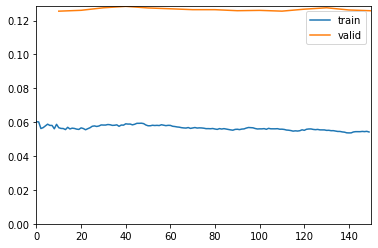

Better model found at epoch 0 with valid_loss value: 0.12556779384613037.


In [45]:
learn.fit_one_cycle(15, max_lr=slice(5e-6, 5e-5),callbacks=[ShowGraph(learn),SaveModelCallback(learn)])

In [0]:
learn.save("model")

In [0]:
learn.export()

In [0]:

#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg.tar.7z | tar xf - -C {path}
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f test-jpg-additional.tar.7z -p {path}  
#! 7za -bd -y -so x {path}/test-jpg-additional.tar.7z | tar xf - -C {path}

In [0]:
test = ImageList.from_folder(path/'test-jpg').add(ImageList.from_folder(path/'test-jpg-additional'))
len(test)

In [0]:

learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [0]:
labelled_preds[:5]

In [0]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])

In [0]:
df.to_csv(path/'submission.csv', index=False)

In [0]:
! kaggle competitions submit planet-understanding-the-amazon-from-space -f {path/'submission.csv'} -m "My submission"

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

In [0]:
path = Path(base_dir + 'data/bears')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [0]:
# ! {sys.executable} -m pip install kaggle --upgrade

In [48]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

# For Windows, uncomment these two commands
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

mv: cannot stat 'kaggle.json': No such file or directory


In [0]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

In [0]:
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
# ! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
# ! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [0]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

In [0]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [0]:

df = pd.read_csv(path/'train_v2.csv')
df.head()